#Baysian Deep Network#

In NN, weights, biases and outputs are optimised to find one optimal value using MLE and differentiations like GD,SGD. 

BNN on other hand marginalises weights and outputs. It treats them as variables and finds their marginal distributions that best fit the data using MAP or predictive distributions like MCMC, Variational Inference.

The ultimate goal of BNN is to quantify the uncertainty introduced by the models in terms of outputs and weights so as to explain the trustworthiness of the prediction.

There are two types of uncertainties.

Aleatory Uncertainty

Aleatory uncertainty is also known as statistical uncertainty. In Statistics, it is representative of unknowns that differ each time we run the same experiment (train the model). In deep learning, it refers to the uncertainty of the model outputs. As shown in the below chart, given that the black line is the prediction and the orange area would be the aleatory uncertainty. You can regard it as the confidence level of the prediction. In the other words, it tells you how confident your prediction result is. If the interval is small, the actual value would have a larger chance to have a closer value towards your prediction value. On the contrary, if the interval is large, the actual value may have a big discrepancy with your prediction value.

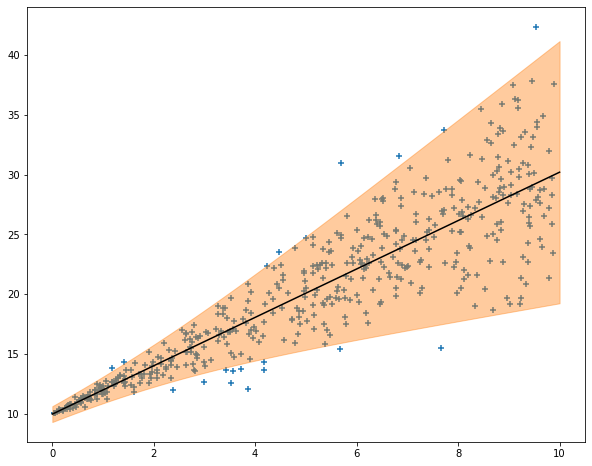

we will implement the BNN model using probabilistic programming with TensorFlow-Probability. 

Epistemic Uncertainty

Epistemic uncertainty is also known as a systematic uncertainty. In deep learning, epistemic uncertainty refers to the uncertainty of the model weights. As shown in the below chart, every time we train the model, the weights may slightly vary. This variation is actually epistemic uncertainty.

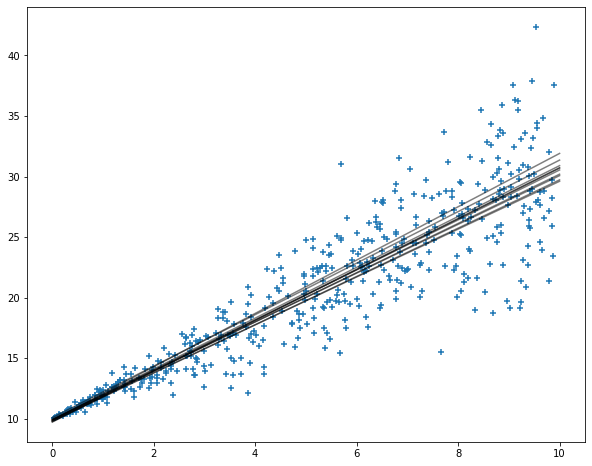


#TensorFlow Probability#

TPF provides integration of probabilistic methods with deep networks, gradient-based inference using automatic differentiation, and scalability to large datasets and models with hardware acceleration (GPUs) and distributed computation,

Our focus is on

1) build different distributions and sample from them.
2)use the bijective function to transform the data.
3)combine the probabilistic layers with Keras to build the BNN model.
4)inference and illustrate different types of uncertainties.

In [ ]:
#pip install tensorflow_probability

#Bijectors#
Bijector is a bijective transformation function between the elements of two sets, where each element of one set is paired with exactly one element of the other set, and each element of the other set is paired with exactly one element of the first set.

Example- as Log, Exp, Sigmoid, Tanh, Softplus, Softsign and etc.

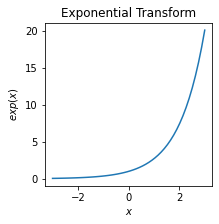

In [ ]:
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt

tfb = tfp.bijectors
exp = tfb.Exp()

x = np.linspace(-3, 3, 50)
y = exp(x)
fig = plt.figure(figsize = (3, 3))
plt.plot(x, y)
plt.title('Exponential Transform')
plt.ylabel('$exp(x)$')
plt.xlabel('$x$')
plt.show()

#Layers#
tfp.layers module switch models from Standard Neural Network into Bayesian Neural Network by replacing the original layers into probabilistic layers. 

DenseVariational: epistemic uncertainty

IndependentNormal: aleatory uncertainty

DistributionLambda: aleatory uncertainty

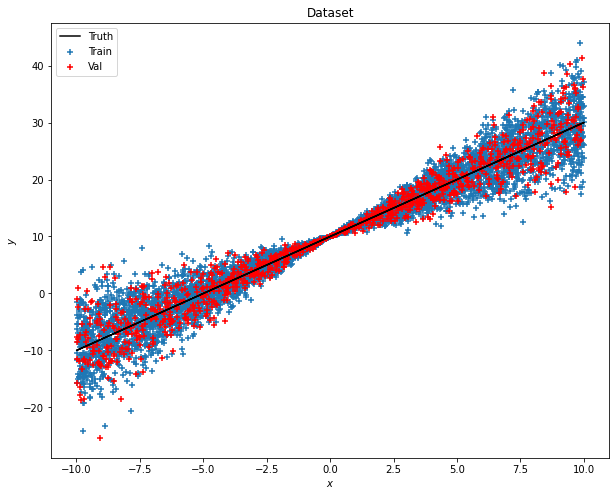

In [ ]:
# Data with heterogeneous variance and visualisation

tfd = tfp.distributions # tensorflow  distributions

def create_dataset(n, x_range, slope=2, intercept=10, noise=0.5):
    x_uniform_dist = tfd.Uniform(low=x_range[0], high=x_range[1])
    x = x_uniform_dist.sample(n).numpy().reshape(-1, 1)
    y_true = slope*x+intercept
    eps_uniform_dist = tfd.Normal(loc=0, scale=1)
    eps = eps_uniform_dist.sample(n).numpy().reshape(-1, 1)*noise*x
    y = y_true + eps
    return x, y, y_true
n_train = 5000
n_val = 1000
n_test = 5000
x_range = [-10, 10]
x_train, y_train, y_true = create_dataset(n_train, x_range)
x_val, y_val, _ = create_dataset(n_val, x_range)
x_test = np.linspace(x_range[0], x_range[1], n_test).reshape(-1, 1)

def plot_dataset(x_train, y_train, x_val, y_val, y_true, title):
    fig = plt.figure(figsize = (10, 8))
    plt.scatter(x_train, y_train, marker='+', label='Train')
    plt.scatter(x_val, y_val, marker='+', color='r', label='Val')
    plt.plot(x_train, y_true, color='k', label='Truth')
    plt.title(title)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.legend()
    plt.show()
plot_dataset(x_train, y_train, x_val, y_val, y_true, 'Dataset')

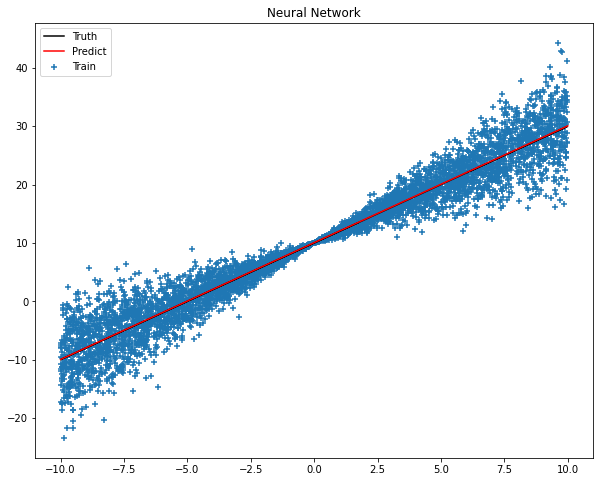

In [ ]:
# Neural Network

import tensorflow as tf
tfkl = tf.keras.layers
# Model Architecture
model = tf.keras.Sequential([tfkl.Dense(1, input_shape = (1,))])
# Model Configuration
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError())
# Early Stopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)
# Model Fitting
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=1000, verbose=False, shuffle=True, callbacks=[callback], batch_size = 100)

y_pred = model.predict(x_test)
fig = plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, marker='+', label='Train')
plt.plot(x_train, y_true, color='k', label='Actual')
plt.plot(x_test, y_pred, color='r', label='Predict')
plt.legend()
plt.title('Neural Network')
plt.show()

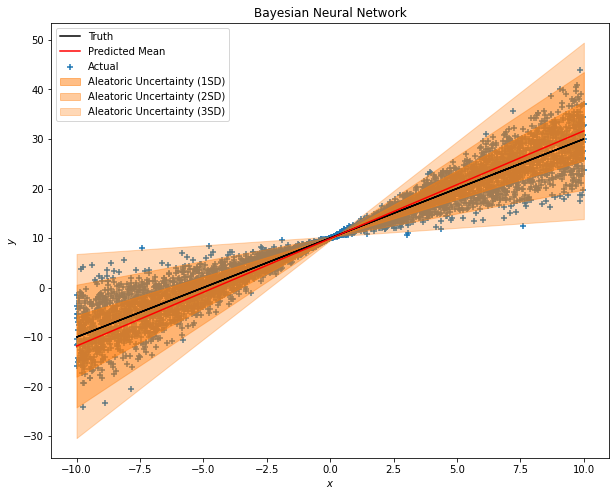

In [ ]:
#Bayesian Neural Network

tfpl = tfp.layers
model = tf.keras.Sequential([
    tfkl.Dense(2, input_shape = (1,)),
    tfpl.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], scale=1e-3+tf.math.abs(t[...,1:])))
])
# mean and standard deviation passed to the normal distribution we have specified in the DistributionLambda layer

negloglik = lambda y_true, y_pred: -y_pred.log_prob(y_true)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)  # Loss is -ve log likelihood instead of MSE

# Early Stopping Callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, min_delta=0, mode='auto', baseline=None, restore_best_weights=True)
# Model Fitting
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10000, verbose=False, shuffle=True, callbacks=[callback], batch_size = 100)

# Summary Statistics
y_pred_mean = model(x_test).mean()
y_pred_std = model(x_test).stddev()

fig = plt.figure(figsize = (10, 8))
plt.scatter(x_train, y_train, marker='+', label='Actual')
plt.plot(x_train, y_true, color='k', label='Truth')
plt.plot(x_test, y_pred_mean, color='r', label='Predicted Mean')
plt.fill_between(x_test.ravel(), np.array(y_pred_mean+1*y_pred_std).ravel(), np.array(y_pred_mean-1*y_pred_std).ravel(), color='C1', alpha=0.5, label='Aleatoric Uncertainty (1SD)')
plt.fill_between(x_test.ravel(), np.array(y_pred_mean+2*y_pred_std).ravel(), np.array(y_pred_mean-2*y_pred_std).ravel(), color='C1', alpha=0.4, label='Aleatoric Uncertainty (2SD)')
plt.fill_between(x_test.ravel(), np.array(y_pred_mean+3*y_pred_std).ravel(), np.array(y_pred_mean-3*y_pred_std).ravel(), color='C1', alpha=0.3, label='Aleatoric Uncertainty (3SD)')
plt.title('Bayesian Neural Network')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.legend()
plt.show()




Classification

In [ ]:
pip install torchbnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt

iris = datasets.load_iris()

X = iris.data
Y = iris.target 

x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
print(x.shape, y.shape)


torch.Size([150, 4]) torch.Size([150])


In [ ]:
#Defining a simple Bayesian model

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=4, out_features=100),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=3),
)   # prior_mu is mean and prior sigma is standard diviation

cross_entropy_loss = nn.CrossEntropyLoss()
klloss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
klweight = 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [ ]:
kl_weight = 0.1

for step in range(3000):
    pre = model(x)
    ce = cross_entropy_loss(pre, y)
    kl = klloss(model)
    cost = ce + kl_weight*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
_, predicted = torch.max(pre.data, 1)
total = y.size(0)
correct = (predicted == y).sum()
print('- Accuracy: %f %%' % (100 * float(correct) / total))
print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

- Accuracy: 98.000000 %
- CE : 0.10, KL : 1.27


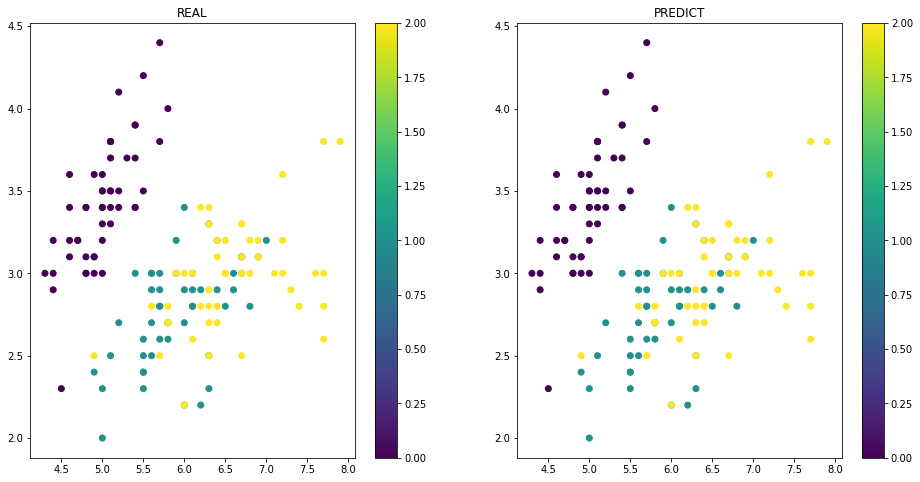

In [ ]:
def draw_plot(predicted) :
    fig = plt.figure(figsize = (16, 8))

    fig_1 = fig.add_subplot(1, 2, 1)
    fig_2 = fig.add_subplot(1, 2, 2)

    z1_plot = fig_1.scatter(X[:, 0], X[:, 1], c = Y)
    z2_plot = fig_2.scatter(X[:, 0], X[:, 1], c = Y)

    plt.colorbar(z1_plot,ax=fig_1)
    plt.colorbar(z2_plot,ax=fig_2)

    fig_1.set_title("REAL")
    fig_2.set_title("PREDICT")

    plt.show()

pre = model(x)
_, predicted = torch.max(pre.data, 1)
draw_plot(predicted)